In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
from pysolar import solar
import datetime

In [3]:
import pathlib 
PATH_EXPORT = pathlib.Path('../results/')

In [4]:
def read_logfile(path):
    df = pd.read_csv(PATH_LOG)
    return df

In [5]:
def take_sample(df,size=1000, random=False):
    if random:
        raise NotImplemented
    
    return df.loc[0:1000].copy()

In [6]:
def calc_pysolar(df):
    df = df.copy()
    
    def calc_zenith(d):
        return 90-solar.get_altitude(d.latitude, d.longitude, 
                                  datetime.datetime.fromisoformat(d.timestamp))
    def calc_azimuth(d):
        return solar.get_azimuth(d.latitude, d.longitude, 
                                 datetime.datetime.fromisoformat(d.timestamp))
    
    df['py_zenith'] = df.apply(calc_zenith, axis=1)
    df['py_azimuth'] = df.apply(calc_azimuth, axis=1) 
    
    df['err_zenith'] = abs(df['zenith']-df['py_zenith'])
    df['err_azimuth'] = abs(df['azimuth']-df['py_azimuth'])
    print('calc_pysolar:       sucess.')
    return df

In [7]:
def parse_timestamp(df):
    df = df.copy()
    df['timestamp'] = df.apply(lambda r: datetime.datetime.fromisoformat(r.timestamp), axis=1)
    df['time'] = df.apply(lambda r: r.timestamp.hour + r.timestamp.minute/60 , axis=1)
    df['doy'] = df.apply(lambda r: r.timestamp.dayofyear, axis=1)
    print('parse_timestamp:    sucess.')
    return df

def discard_outliers(df, threshold=10):
    orig = len(df)
    df = df.copy()
    df = df[df['err_azimuth']<threshold]
    df = df[df['err_zenith']<threshold]
    new = len(df)
    print(f'discard_outliers:   {orig-new} verworfen')
    return df

In [8]:
PATH_LOG = "../results/log_rLoc_allHour3.csv"
dataRaw = read_logfile(PATH_LOG)

data = (dataRaw#.pipe(take_sample)
        .pipe(calc_pysolar)
        .pipe(parse_timestamp)
        .pipe(discard_outliers)
       )

data.head()

calc_pysolar:       sucess.
parse_timestamp:    sucess.
discard_outliers:   0 verworfen


,latitude,longitude,height,timestamp,zenith,azimuth,py_zenith,py_azimuth,err_zenith,err_azimuth,time,doy
0,-56.0,-26.0,0,2014-09-10 00:00:00+00:00,125.209583,211.391778,125.209051,211.395183,0.000532,0.003405,0.0,253
1,-56.0,-26.0,0,2014-09-10 01:00:00+00:00,128.374278,193.118611,128.374229,193.122228,0.000049,0.003617,1.0,253
2,-56.0,-26.0,0,2014-09-10 02:00:00+00:00,128.877444,173.964000,128.877939,173.967600,0.000495,0.003600,2.0,253
3,-56.0,-26.0,0,2014-09-10 03:00:00+00:00,126.631556,155.240611,126.632510,155.243941,0.000954,0.003330,3.0,253
4,-56.0,-26.0,0,2014-09-10 04:00:00+00:00,122.000139,138.003472,122.001465,138.006423,0.001326,0.002951,4.0,253


In [9]:
def calc_statistic(df, name):
    sample = df[name]
    print(f'Statistik:  {name}')
    print(f'Samplesize: {len(sample)}')
    print(f'Mean:       {sample.mean()}')
    print(f'std:        {sample.std()}')
    print(f'min:        {sample.min()}')
    print(f'max:        {sample.max()}\n')

In [10]:
calc_statistic(data, 'err_zenith')
calc_statistic(data, 'err_azimuth')

Statistik:  err_zenith
Samplesize: 24624
Mean:       0.041250433947260134
std:        0.08274616870409642
min:        5.785489491927365e-07
max:        0.6150721704864281

Statistik:  err_azimuth
Samplesize: 24624
Mean:       0.006836993056942541
std:        0.00952483576474908
min:        2.0580881709975074e-07
max:        0.6042969952804356



In [11]:
data.timestamp.min()
len(data)/24

1026.0

# Auswertung

In [46]:
def get_world_plot(figsize=(8,4)):
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    fig, ax = plt.subplots(figsize=figsize)
    countries.plot(color="lightgray", ax=ax)
    ax.set_xlabel('longitude [°]')
    ax.set_ylabel('latitude [°]')
    return fig, ax

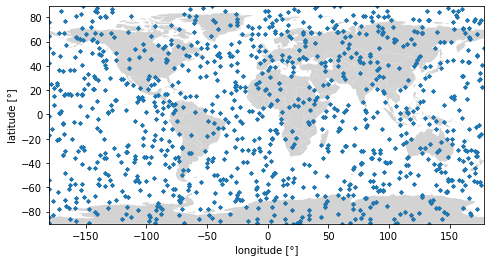

In [47]:
fig,ax = get_world_plot()
data.plot.scatter(x='longitude',y='latitude',ax=ax, s=5)
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
ax.set_xlim(data.longitude.min(), data.longitude.max())
ax.set_ylim(data.latitude.min(), data.latitude.max())
plt.savefig(PATH_EXPORT/'worldmap.png', dpi=300, bbox_inches='tight')
plt.show()

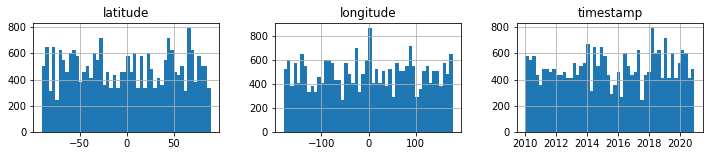

In [48]:
data.hist(bins=50, column=['latitude', 'longitude', 'timestamp'], layout=(1,3),figsize=(12,2) )
plt.savefig(PATH_EXPORT/'histogram.png', dpi=300, bbox_inches='tight')
plt.show()

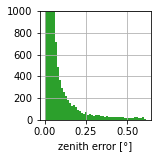

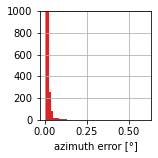

In [49]:
data.hist(bins=50, column='err_zenith',figsize=(2,2), color='tab:green')
axs=plt.gcf().axes
for ax in axs:
    ax.set_ylim(0,1000)
    ax.set_title('')
    ax.set_xlabel('zenith error [°]')
plt.savefig(PATH_EXPORT/'histogram_zenith.png', dpi=300, bbox_inches='tight')
plt.show()

data.hist(bins=50, column='err_azimuth',figsize=(2,2), color='tab:red')
axs=plt.gcf().axes
for ax in axs:
    ax.set_ylim(0,1000)
    ax.set_title('')
    ax.set_xlabel('azimuth error [°]')
plt.savefig(PATH_EXPORT/'histogram_azimuth.png', dpi=300, bbox_inches='tight')
plt.show()


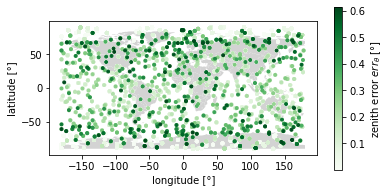

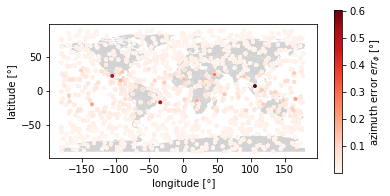

In [50]:
# Fehlerverteilung Global
fig, ax = get_world_plot(figsize=(6,3))
data.sort_values(by=['err_zenith']).plot.scatter(x="longitude", y="latitude",ax=ax,
                                                 c='err_zenith',s=8, cmap='Greens')
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
plt.gcf().axes[1].set_ylabel('zenith error $err_\\theta$ [°]')
plt.savefig(PATH_EXPORT/'worldmap_err_zenith.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = get_world_plot(figsize=(6,3))
data.sort_values(by=['err_azimuth']).plot.scatter(x="longitude", y="latitude",ax=ax,
                                                c='err_azimuth',s=8, cmap='Reds')
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
plt.gcf().axes[1].set_ylabel('azimuth error $err_\\phi$ [°]')

plt.savefig(PATH_EXPORT/'worldmap_err_azimuth.png', dpi=300, bbox_inches='tight')
plt.show()



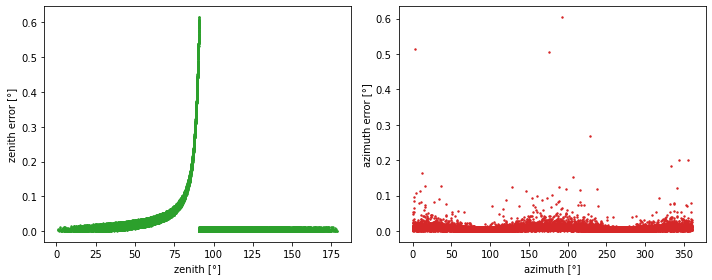

In [51]:
# Fehler in Abhängigkeit der Messgröße
fig, axs = plt.subplots(1,2, figsize=(10,4))
data.plot.scatter(x='zenith', y='err_zenith', ax=axs[0],s=2, color='tab:green')
data.plot.scatter(x='azimuth', y='err_azimuth', ax=axs[1],s=2, color='tab:red')
axs[0].set_xlabel('zenith [°]')
axs[1].set_xlabel('azimuth [°]')
axs[0].set_ylabel('zenith error [°]')
axs[1].set_ylabel('azimuth error [°]')
plt.savefig(PATH_EXPORT/'err_value_A.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

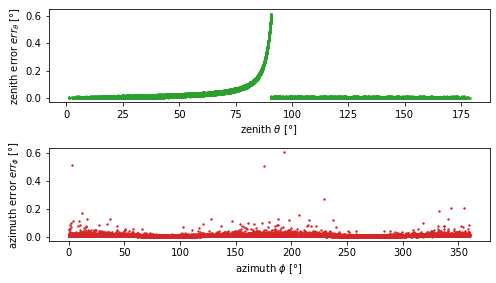

In [58]:
# Fehler in Abhängigkeit der Messgröße
fig, axs = plt.subplots(2,1, figsize=(7,4))
data.plot.scatter(x='zenith', y='err_zenith', ax=axs[0],s=2, color='tab:green')
data.plot.scatter(x='azimuth', y='err_azimuth', ax=axs[1],s=2, color='tab:red')
axs[0].set_xlabel('zenith $\\theta$ [°]')
axs[1].set_xlabel('azimuth $\\phi$ [°]')
axs[0].set_ylabel('zenith error $err_\\theta$ [°]')
axs[1].set_ylabel('azimuth error $err_\\phi$ [°]')
plt.tight_layout()
plt.savefig(PATH_EXPORT/'err_value_B.png', dpi=300, bbox_inches='tight')


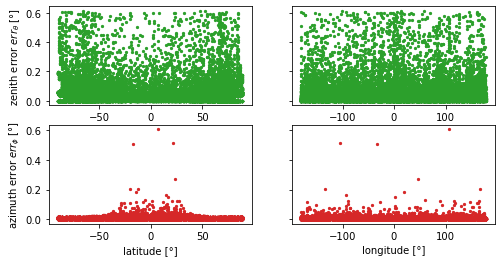

In [53]:
# Abhängigkeit von Latitude/Longitude
fig,axs = plt.subplots(2,2, figsize=(8,4), sharey='row')
data.plot.scatter(x='latitude',y='err_zenith', ax=axs[0][0],c='tab:green',s=5, )
data.plot.scatter(x='longitude',y='err_zenith', ax=axs[0][1],  c='tab:green',s=5)
data.plot.scatter(x='latitude',y='err_azimuth', ax=axs[1][0],c='tab:red',s=5)
data.plot.scatter(x='longitude',y='err_azimuth', ax=axs[1][1], c='tab:red',s=5 )
axs[1][0].set_xlabel('latitude [°]')
axs[1][1].set_xlabel('longitude [°]')
axs[0][0].set_ylabel('zenith error $err_\\theta$ [°]')
axs[1][0].set_ylabel('azimuth error $err_\\phi$ [°]')
plt.savefig(PATH_EXPORT/'err_LatLon.png', dpi=300, bbox_inches='tight')
plt.show()

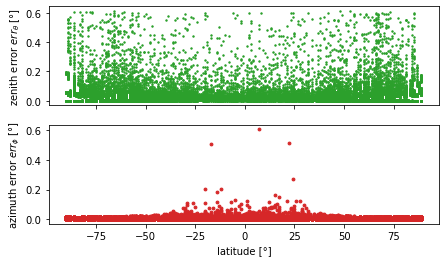

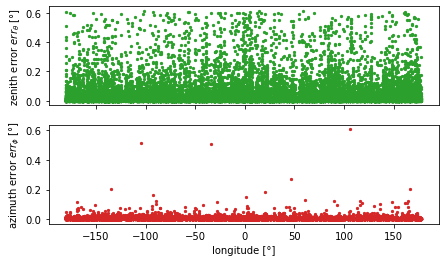

In [59]:
# Abhängigkeit von Latitude/Longitude
fig,(ax,bx) = plt.subplots(2,1, figsize=(7,4), sharex=True)
data.plot.scatter(x='latitude',y='err_zenith', ax=ax,c='tab:green',s=2, )
# data.plot.scatter(x='longitude',y='err_zenith', ax=ax,  c='tab:green',s=5)
data.plot.scatter(x='latitude',y='err_azimuth', ax=bx,c='tab:red',s=8)
# data.plot.scatter(x='longitude',y='err_azimuth', ax=ax, c='tab:red',s=5 )
bx.set_xlabel('latitude [°]')
ax.set_ylabel('zenith error $err_\\theta$ [°]')
bx.set_ylabel('azimuth error $err_\\phi$ [°]')
plt.savefig(PATH_EXPORT/'err_latitude.png', dpi=300, bbox_inches='tight')
plt.show()

# Abhängigkeit von Latitude/Longitude
fig,(ax,bx) = plt.subplots(2,1, figsize=(7,4), sharex=True)
# data.plot.scatter(x='latitude',y='err_zenith', ax=ax,c='tab:green',s=2, )
data.plot.scatter(x='longitude',y='err_zenith', ax=ax,  c='tab:green',s=5)
# data.plot.scatter(x='latitude',y='err_azimuth', ax=bx,c='tab:red',s=8)
data.plot.scatter(x='longitude',y='err_azimuth', ax=bx, c='tab:red',s=5 )
bx.set_xlabel('longitude [°]')
ax.set_ylabel('zenith error $err_\\theta$ [°]')
bx.set_ylabel('azimuth error $err_\\phi$ [°]')
plt.savefig(PATH_EXPORT/'err_longitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# # Ausreißerverteilung Global
# schwelle = 0.5
# subsetAlt = data[(data["err_zenith"]>schwelle)]
# subsetAz = data[(data["err_azimuth"]>schwelle)]


# fig, ax = get_world_plot()
# subsetAlt.plot.scatter(x="longitude", y="latitude",ax=ax,s=8)
# print("Ausreißer zenith:",len(subsetAlt),"von", len(data))
# plt.show()


# fig, ax = get_world_plot()
# subsetAz.plot.scatter(x="longitude", y="latitude",ax=ax,s=8)
# print("Ausreißer Azimuth:",len(subsetAz),"von", len(data))
# plt.show()

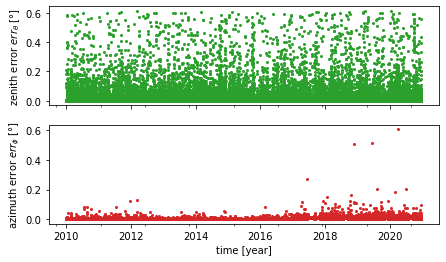

In [56]:
fig,(ax,bx) = plt.subplots(2,1, figsize=(7,4), sharex=True)
data.sort_values(by=['timestamp']).plot.scatter(x='timestamp', y='err_zenith',ax=ax, c='tab:green',s=4)
data.sort_values(by=['timestamp']).plot.scatter(x='timestamp', y='err_azimuth', ax=bx,c='tab:red', s=4)
ax.set_ylabel('zenith error $err_\\theta$ [°]')
bx.set_ylabel('azimuth error $err_\\phi$ [°]')
bx.set_xlabel('time [year]')
plt.savefig(PATH_EXPORT/'err_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# import itertools
# features = ['time','doy','latitude','longitude','azimuth', 'zenith']
# for a,b in itertools.combinations(features,2):
#     fig, (ax,bx) = plt.subplots(1,2, figsize=(12,6))
#     data.plot.scatter(x=a, y=b, c='err_zenith',cmap='Reds',ax=ax)
#     data.plot.scatter(x=a, y=b, c='err_azimuth',cmap='Greens',ax=bx)
#     plt.show()
    